
# Fused Attention

This is a Triton implementation of the Flash Attention v2 algorithm from Tri Dao (https://tridao.me/publications/flash2/flash2.pdf)
Credits: OpenAI kernel team

Extra Credits:
- Original flash attention paper (https://arxiv.org/abs/2205.14135)
- Rabe and Staats (https://arxiv.org/pdf/2112.05682v2.pdf)


In [1]:
import os

# This is currently (Apr 2024) required to enable deterministic (and hence reproducible) behavior
# It must be set before importing torch
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import math

import pytest
import torch
import torch.nn as nn

import triton
import triton.language as tl

In [17]:
V = torch.cuda.BFloat16Tensor([[1.1, 1.2], [2.3, 2.4]])
type(tl.float8e5)

triton.language.core.dtype

In [64]:
@triton.jit
def _attn_fwd_inner(acc, l_i, m_i, q,  #
                    K_block_ptr, V_block_ptr,  #
                    start_m, qk_scale,  #
                    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr, BLOCK_N: tl.constexpr,  #
                    STAGE: tl.constexpr, offs_m: tl.constexpr, offs_n: tl.constexpr,  #
                    N_CTX: tl.constexpr, fp8_v: tl.constexpr):
    # range of values handled by this stage
    if STAGE == 1:
        lo, hi = 0, start_m * BLOCK_M
    elif STAGE == 2:
        lo, hi = start_m * BLOCK_M, (start_m + 1) * BLOCK_M
        lo = tl.multiple_of(lo, BLOCK_M)
    # causal = False
    else:
        lo, hi = 0, N_CTX
    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))
    # loop over k, v and update accumulator
    for start_n in range(lo, hi, BLOCK_N):
        start_n = tl.multiple_of(start_n, BLOCK_N)
        # -- compute qk ----
        k = tl.load(K_block_ptr)
        qk = tl.dot(q, k)
        if STAGE == 2:
            mask = offs_m[:, None] >= (start_n + offs_n[None, :])
            qk = qk * qk_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(qk, 1))
            qk -= m_ij[:, None]
        else:
            m_ij = tl.maximum(m_i, tl.max(qk, 1) * qk_scale)
            qk = qk * qk_scale - m_ij[:, None]
        p = tl.math.exp2(qk)
        l_ij = tl.sum(p, 1)
        # -- update m_i and l_i
        alpha = tl.math.exp2(m_i - m_ij)
        l_i = l_i * alpha + l_ij
        # -- update output accumulator --
        acc = acc * alpha[:, None]
        # update acc
        v = tl.load(V_block_ptr)
        if fp8_v:
            p = p.to(tl.float8e5)
        else:
            p = p.to(tl.bfloat16)
        acc = tl.dot(p, v, acc)
        # update m_i and l_i
        m_i = m_ij
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_N, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_N))
    return acc, l_i, m_i


# We don't run auto-tuning every time to keep the tutorial fast. Uncommenting
# the code below and commenting out the equivalent parameters is convenient for
# re-tuning.
@triton.autotune(
   configs=[
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=4, num_warps=8),
       triton.Config({'BLOCK_M': 256, 'BLOCK_N': 64}, num_stages=3, num_warps=8),
       triton.Config({'BLOCK_M': 256, 'BLOCK_N': 32}, num_stages=3, num_warps=8),
       triton.Config({'BLOCK_M': 256, 'BLOCK_N': 32}, num_stages=3, num_warps=4),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=3, num_warps=4),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=4, num_warps=4),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=3, num_warps=4),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=4, num_warps=4),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=3, num_warps=8),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=7, num_warps=8),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=7, num_warps=8),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=6, num_warps=8),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=5, num_warps=8),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32}, num_stages=4, num_warps=8),
       triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64}, num_stages=6, num_warps=4),
   ],
   key=['N_CTX'],
)


@triton.jit
def _attn_fwd(Q, K, V, sm_scale, M, Out,  #
              stride_qz, stride_qh, stride_qm, stride_qk,  #
              stride_kz, stride_kh, stride_kn, stride_kk,  #
              stride_vz, stride_vh, stride_vk, stride_vn,  #
              stride_oz, stride_oh, stride_om, stride_on,  #
              Z, H,  #
              N_CTX: tl.constexpr,  #
              BLOCK_M: tl.constexpr,  #
              BLOCK_DMODEL: tl.constexpr,  #
              BLOCK_N: tl.constexpr,  #
              STAGE: tl.constexpr  #
              ):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    off_z = off_hz // H
    off_h = off_hz % H
    qvk_offset = off_z.to(tl.int64) * stride_qz + off_h.to(tl.int64) * stride_qh

    # block pointers
    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_qm, stride_qk),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0),
    )
    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_vk, stride_vn),
        offsets=(0, 0),
        block_shape=(BLOCK_N, BLOCK_DMODEL),
        order=(0, 1) if V.dtype.element_ty == tl.float8e5 else (1, 0),
    )
    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(BLOCK_DMODEL, N_CTX),
        strides=(stride_kk, stride_kn),
        offsets=(0, 0),
        block_shape=(BLOCK_DMODEL, BLOCK_N),
        order=(0, 1),
    )
    O_block_ptr = tl.make_block_ptr(
        base=Out + qvk_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_om, stride_on),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0),
    )
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    # initialize pointer to m and l
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32) + 1.0
    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
    # load scales
    qk_scale = sm_scale
    qk_scale *= 1.44269504  # 1/log(2)
    # load q: it will stay in SRAM throughout
    q = tl.load(Q_block_ptr)
    # stage 1: off-band
    # For causal = True, STAGE = 3 and _attn_fwd_inner gets 1 as its STAGE
    # For causal = False, STAGE = 1, and _attn_fwd_inner gets 3 as its STAGE
    if STAGE & 1:
        acc, l_i, m_i = _attn_fwd_inner(acc, l_i, m_i, q, K_block_ptr, V_block_ptr,  #
                                        start_m, qk_scale,  #
                                        BLOCK_M, BLOCK_DMODEL, BLOCK_N,  #
                                        4 - STAGE, offs_m, offs_n, N_CTX, V.dtype.element_ty == tl.float8e5  #
                                        )
    # stage 2: on-band
    if STAGE & 2:
        # barrier makes it easier for compielr to schedule the
        # two loops independently
        tl.debug_barrier()
        acc, l_i, m_i = _attn_fwd_inner(acc, l_i, m_i, q, K_block_ptr, V_block_ptr,  #
                                        start_m, qk_scale,  #
                                        BLOCK_M, BLOCK_DMODEL, BLOCK_N,  #
                                        2, offs_m, offs_n, N_CTX, V.dtype.element_ty == tl.float8e5  #
                                        )
    # epilogue
    m_i += tl.math.log2(l_i)
    acc = acc / l_i[:, None]
    m_ptrs = M + off_hz * N_CTX + offs_m
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, acc.to(Out.type.element_ty))


@triton.jit
def _attn_bwd_preprocess(O, DO,  #
                         Delta,  #
                         Z, H, N_CTX,  #
                         BLOCK_M: tl.constexpr, D_HEAD: tl.constexpr  #
                         ):
    off_m = tl.program_id(0) * BLOCK_M + tl.arange(0, BLOCK_M)
    off_hz = tl.program_id(1)
    off_n = tl.arange(0, D_HEAD)
    # load
    o = tl.load(O + off_hz * D_HEAD * N_CTX + off_m[:, None] * D_HEAD + off_n[None, :])
    do = tl.load(DO + off_hz * D_HEAD * N_CTX + off_m[:, None] * D_HEAD + off_n[None, :]).to(tl.float32)
    delta = tl.sum(o * do, axis=1)
    # write-back
    tl.store(Delta + off_hz * N_CTX + off_m, delta)


# The main inner-loop logic for computing dK and dV.
@triton.jit
def _attn_bwd_dkdv(dk, dv,  #
                   Q, k, v, sm_scale,  #
                   DO,  #
                   M, D,  #
                   # shared by Q/K/V/DO.
                   stride_tok, stride_d,  #
                   H, N_CTX, BLOCK_M1: tl.constexpr,  #
                   BLOCK_N1: tl.constexpr,  #
                   BLOCK_DMODEL: tl.constexpr,  #
                   # Filled in by the wrapper.
                   start_n, start_m, num_steps,  #
                   MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M1)
    offs_n = start_n + tl.arange(0, BLOCK_N1)
    offs_k = tl.arange(0, BLOCK_DMODEL)
    qT_ptrs = Q + offs_m[None, :] * stride_tok + offs_k[:, None] * stride_d
    do_ptrs = DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    # BLOCK_N1 must be a multiple of BLOCK_M1, otherwise the code wouldn't work.
    tl.static_assert(BLOCK_N1 % BLOCK_M1 == 0)
    curr_m = start_m
    step_m = BLOCK_M1
    for blk_idx in range(num_steps):
        qT = tl.load(qT_ptrs)
        # Load m before computing qk to reduce pipeline stall.
        offs_m = curr_m + tl.arange(0, BLOCK_M1)
        m = tl.load(M + offs_m)
        qkT = tl.dot(k, qT)
        pT = tl.math.exp2(qkT - m[None, :])
        # Autoregressive masking.
        if MASK:
            mask = (offs_m[None, :] >= offs_n[:, None])
            pT = tl.where(mask, pT, 0.0)
        do = tl.load(do_ptrs)
        # Compute dV.
        ppT = pT
        ppT = ppT.to(tl.bfloat16)
        dv += tl.dot(ppT, do)
        # D (= delta) is pre-divided by ds_scale.
        Di = tl.load(D + offs_m)
        # Compute dP and dS.
        dpT = tl.dot(v, tl.trans(do)).to(tl.float32)
        dsT = pT * (dpT - Di[None, :])
        dsT = dsT.to(tl.bfloat16)
        dk += tl.dot(dsT, tl.trans(qT))
        # Increment pointers.
        curr_m += step_m
        qT_ptrs += step_m * stride_tok
        do_ptrs += step_m * stride_tok
    return dk, dv


# the main inner-loop logic for computing dQ
@triton.jit
def _attn_bwd_dq(dq, q, K, V,  #
                 do, m, D,
                 # shared by Q/K/V/DO.
                 stride_tok, stride_d,  #
                 H, N_CTX,  #
                 BLOCK_M2: tl.constexpr,  #
                 BLOCK_N2: tl.constexpr,  #
                 BLOCK_DMODEL: tl.constexpr,
                 # Filled in by the wrapper.
                 start_m, start_n, num_steps,  #
                 MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M2)
    offs_n = start_n + tl.arange(0, BLOCK_N2)
    offs_k = tl.arange(0, BLOCK_DMODEL)
    kT_ptrs = K + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    vT_ptrs = V + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    # D (= delta) is pre-divided by ds_scale.
    Di = tl.load(D + offs_m)
    # BLOCK_M2 must be a multiple of BLOCK_N2, otherwise the code wouldn't work.
    tl.static_assert(BLOCK_M2 % BLOCK_N2 == 0)
    curr_n = start_n
    step_n = BLOCK_N2
    for blk_idx in range(num_steps):
        kT = tl.load(kT_ptrs)
        vT = tl.load(vT_ptrs)
        qk = tl.dot(q, kT)
        p = tl.math.exp2(qk - m)
        # Autoregressive masking.
        if MASK:
            offs_n = curr_n + tl.arange(0, BLOCK_N2)
            mask = (offs_m[:, None] >= offs_n[None, :])
            p = tl.where(mask, p, 0.0)
        # Compute dP and dS.
        dp = tl.dot(do, vT).to(tl.float32)
        ds = p * (dp - Di[:, None])
        ds = ds.to(tl.bfloat16)
        # Compute dQ.
        # NOTE: We need to de-scale dq in the end, because kT was pre-scaled.
        dq += tl.dot(ds, tl.trans(kT))
        # Increment pointers.
        curr_n += step_n
        kT_ptrs += step_n * stride_tok
        vT_ptrs += step_n * stride_tok
    return dq


@triton.jit
def _attn_bwd(Q, K, V, sm_scale,  #
              DO,  #
              DQ, DK, DV,  #
              M, D,
              # shared by Q/K/V/DO.
              stride_z, stride_h, stride_tok, stride_d,  #
              H, N_CTX,  #
              BLOCK_M1: tl.constexpr,  #
              BLOCK_N1: tl.constexpr,  #
              BLOCK_M2: tl.constexpr,  #
              BLOCK_N2: tl.constexpr,  #
              BLK_SLICE_FACTOR: tl.constexpr,  #
              BLOCK_DMODEL: tl.constexpr):
    LN2: tl.constexpr = 0.6931471824645996  # = ln(2)

    bhid = tl.program_id(2)
    off_chz = (bhid * N_CTX).to(tl.int64)
    adj = (stride_h * (bhid % H) + stride_z * (bhid // H)).to(tl.int64)
    pid = tl.program_id(0)

    # offset pointers for batch/head
    Q += adj
    K += adj
    V += adj
    DO += adj
    DQ += adj
    DK += adj
    DV += adj
    M += off_chz
    D += off_chz

    # load scales
    offs_k = tl.arange(0, BLOCK_DMODEL)

    start_n = pid * BLOCK_N1
    start_m = start_n

    MASK_BLOCK_M1: tl.constexpr = BLOCK_M1 // BLK_SLICE_FACTOR
    offs_n = start_n + tl.arange(0, BLOCK_N1)

    dv = tl.zeros([BLOCK_N1, BLOCK_DMODEL], dtype=tl.float32)
    dk = tl.zeros([BLOCK_N1, BLOCK_DMODEL], dtype=tl.float32)

    # load K and V: they stay in SRAM throughout the inner loop.
    k = tl.load(K + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)
    v = tl.load(V + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)

    num_steps = BLOCK_N1 // MASK_BLOCK_M1

    dk, dv = _attn_bwd_dkdv(dk, dv,  #
                            Q, k, v, sm_scale,  #
                            DO,  #
                            M, D,  #
                            stride_tok, stride_d,  #
                            H, N_CTX,  #
                            MASK_BLOCK_M1, BLOCK_N1, BLOCK_DMODEL,  #
                            start_n, start_m, num_steps,  #
                            MASK=True  #
                            )

    start_m += num_steps * MASK_BLOCK_M1
    num_steps = (N_CTX - start_m) // BLOCK_M1

    # Compute dK and dV for non-masked blocks.
    dk, dv = _attn_bwd_dkdv(  #
        dk, dv,  #
        Q, k, v, sm_scale,  #
        DO,  #
        M, D,  #
        stride_tok, stride_d,  #
        H, N_CTX,  #
        BLOCK_M1, BLOCK_N1, BLOCK_DMODEL,  #
        start_n, start_m, num_steps,  #
        MASK=False  #
    )

    dv_ptrs = DV + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dv_ptrs, dv)

    # Write back dK.
    dk *= sm_scale
    dk_ptrs = DK + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dk_ptrs, dk)

    # THIS BLOCK DOES DQ:
    start_m = pid * BLOCK_M2
    end_n = start_m + BLOCK_M2

    MASK_BLOCK_N2: tl.constexpr = BLOCK_N2 // BLK_SLICE_FACTOR
    offs_m = start_m + tl.arange(0, BLOCK_M2)

    q = tl.load(Q + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)
    dq = tl.zeros([BLOCK_M2, BLOCK_DMODEL], dtype=tl.float32)
    do = tl.load(DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)

    m = tl.load(M + offs_m)
    m = m[:, None]

    # Compute dQ for masked (diagonal) blocks.
    # NOTE: This code scans each row of QK^T backward (from right to left,
    # but inside each call to _attn_bwd_dq, from left to right), but that's
    # not due to anything important.  I just wanted to reuse the loop
    # structure for dK & dV above as much as possible.
    num_steps = BLOCK_M2 // MASK_BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V,  #
                      do, m, D,  #
                      stride_tok, stride_d,  #
                      H, N_CTX,  #
                      BLOCK_M2, MASK_BLOCK_N2, BLOCK_DMODEL,  #
                      start_m, end_n - num_steps * MASK_BLOCK_N2, num_steps,  #
                      MASK=True  #
                      )
    end_n -= num_steps * MASK_BLOCK_N2
    # stage 2
    num_steps = end_n // BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V,  #
                      do, m, D,  #
                      stride_tok, stride_d,  #
                      H, N_CTX,  #
                      BLOCK_M2, BLOCK_N2, BLOCK_DMODEL,  #
                      start_m, end_n - num_steps * BLOCK_N2, num_steps,  #
                      MASK=False  #
                      )
    # Write back dQ.
    dq_ptrs = DQ + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    dq *= LN2
    tl.store(dq_ptrs, dq)


empty = torch.empty(128, device="cuda")


class TritonAttention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, is_causal):
        # shape constraints
        Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
        sm_scale = 1 / math.sqrt(Lk)
        # when v is in float8_e5m2 it is transposed.
        assert Lq == Lk and (Lk == Lv or v.dtype == torch.float8_e5m2)
        assert Lk in {16, 32, 64, 128, 256}
        o = torch.empty_like(q)
        BLOCK_M = 128
        BLOCK_N = 64 if Lk <= 64 else 32
        num_stages = 4 if Lk <= 64 else 3
        num_warps = 4
        stage = 3 if is_causal else 1
        # Tuning for H100
        if torch.cuda.get_device_capability()[0] == 9:
            num_warps = 8
            num_stages = 7 if Lk >= 64 else 3
            if v.dtype == torch.float8_e5m2:
                if Lk < 256:
                    BLOCK_M = 64 if not is_causal else 128
                    BLOCK_N = 128
                    num_stages = 3 if Lk == 128 else 4
                    num_warps = 4
                else:
                    BLOCK_M = 128
                    BLOCK_N = 128
                    num_stages = 3
                    num_warps = 8
        grid = (triton.cdiv(q.shape[2], BLOCK_M), q.shape[0] * q.shape[1], 1)
        M = torch.empty((q.shape[0], q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        _attn_fwd[grid](
            q, k, v, sm_scale, M, o,  #
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),  #
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),  #
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),  #
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),  #
            q.shape[0], q.shape[1],  #
            N_CTX=q.shape[2],  #
            # BLOCK_M=BLOCK_M,  #
            # BLOCK_N=BLOCK_N,  #
            BLOCK_DMODEL=Lk,  #
            STAGE=stage,  #
            # num_warps=num_warps,  #
            # num_stages=num_stages  #
        )

        ctx.save_for_backward(q, k, v, o, M)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.BLOCK_DMODEL = Lk
        ctx.causal = is_causal
        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, M = ctx.saved_tensors
        do = do.contiguous()
        assert do.is_contiguous()
        assert q.stride() == k.stride() == v.stride() == o.stride() == do.stride()
        dq = torch.empty_like(q)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        BATCH, N_HEAD, N_CTX = q.shape[:3]
        PRE_BLOCK = 128
        NUM_WARPS, NUM_STAGES = 4, 5
        BLOCK_M1, BLOCK_N1, BLOCK_M2, BLOCK_N2 = 32, 128, 128, 32
        BLK_SLICE_FACTOR = 2
        RCP_LN2 = 1.4426950408889634  # = 1.0 / ln(2)
        arg_k = k
        arg_k = arg_k * (ctx.sm_scale * RCP_LN2)
        PRE_BLOCK = 128
        assert N_CTX % PRE_BLOCK == 0
        pre_grid = (N_CTX // PRE_BLOCK, BATCH * N_HEAD)
        delta = torch.empty_like(M)
        _attn_bwd_preprocess[pre_grid](
            o, do,  #
            delta,  #
            BATCH, N_HEAD, N_CTX,  #
            BLOCK_M=PRE_BLOCK, D_HEAD=ctx.BLOCK_DMODEL  #
        )
        grid = (N_CTX // BLOCK_N1, 1, BATCH * N_HEAD)
        _attn_bwd[grid](
            q, arg_k, v, ctx.sm_scale, do, dq, dk, dv,  #
            M, delta,  #
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),  #
            N_HEAD, N_CTX,  #
            BLOCK_M1=BLOCK_M1, BLOCK_N1=BLOCK_N1,  #
            BLOCK_M2=BLOCK_M2, BLOCK_N2=BLOCK_N2,  #
            BLK_SLICE_FACTOR=BLK_SLICE_FACTOR,  #
            BLOCK_DMODEL=ctx.BLOCK_DMODEL,  #
            num_warps=NUM_WARPS,  #
            num_stages=NUM_STAGES  #
        )

        return dq, dk, dv, None, None


attention = TritonAttention.apply

In [4]:
@pytest.mark.parametrize("Z, H, N_CTX, D_HEAD", [(1, 2, 1024, 64)])
@pytest.mark.parametrize("causal", [True])
def test_op(Z, H, N_CTX, D_HEAD, causal, dtype=torch.bfloat16):
    torch.manual_seed(20)
    q = (torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    k = (torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    v = (torch.empty((Z, H, N_CTX, D_HEAD), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    sm_scale = 0.5
    dout = torch.randn_like(q)
    # reference implementation
    M = torch.tril(torch.ones((N_CTX, N_CTX), device="cuda"))
    p = torch.matmul(q, k.transpose(2, 3)) * sm_scale
    if causal:
        p[:, :, M == 0] = float("-inf")
    p = torch.softmax(p.float(), dim=-1).half()
    # p = torch.exp(p)
    ref_out = torch.matmul(p, v)
    ref_out.backward(dout)
    ref_dv, v.grad = v.grad.clone(), None
    ref_dk, k.grad = k.grad.clone(), None
    ref_dq, q.grad = q.grad.clone(), None
    # triton implementation
    tri_out = attention(q, k, v, causal, sm_scale).half()
    tri_out.backward(dout)
    tri_dv, v.grad = v.grad.clone(), None
    tri_dk, k.grad = k.grad.clone(), None
    tri_dq, q.grad = q.grad.clone(), None
    # compare
    assert torch.allclose(ref_out, tri_out, atol=1e-2, rtol=0)
    assert torch.allclose(ref_dv, tri_dv, atol=1e-2, rtol=0)
    assert torch.allclose(ref_dk, tri_dk, atol=1e-2, rtol=0)
    assert torch.allclose(ref_dq, tri_dq, atol=1e-2, rtol=0)

In [4]:
from torch.nn.functional import scaled_dot_product_attention 

TORCH_HAS_FP8 = hasattr(torch, 'float8_e5m2')
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 12, 256, 64
# vary seq length for fixed head and batch=4
configs = []
for mode in ["fwd", "bwd"]:
    for causal in [True, False]:
        for fp8_inputs in [False, True]:
            if fp8_inputs and ((not TORCH_HAS_FP8) or mode == "bwd"):
                continue
            if mode == "bwd" and not causal:
                continue
            configs.append(
                triton.testing.Benchmark(
                    x_names=["N_CTX"],
                    x_vals=[2**i for i in range(10, 15)],
                    line_arg="provider",
                    line_vals=["triton", "torch"],
                    line_names=["Triton", "Pytorch"],
                    styles=[("red", "-"), ("blue", "-")],
                    ylabel="ms",
                    plot_name=
                    f"fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}-{mode}-causal={causal}-fp8={fp8_inputs}",
                    args={
                        "H": N_HEADS,
                        "BATCH": BATCH,
                        "D_HEAD": D_HEAD,
                        "dtype": torch.float16,
                        "mode": mode,
                        "causal": causal,
                        "fp8_inputs": fp8_inputs,
                    },
                ))

@triton.testing.perf_report(configs)
def bench_flash_attention(BATCH, H, N_CTX, D_HEAD, causal, mode, provider, fp8_inputs, dtype=torch.float16,
                          device="cuda"):
    assert mode in ["fwd", "bwd"]
    warmup = 200  # 25
    rep = 100
    if provider == "triton":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        if mode == "fwd" and TORCH_HAS_FP8 and fp8_inputs:
            q = q.to(torch.float8_e5m2)
            k = k.to(torch.float8_e5m2)
            v = v.permute(0, 1, 3, 2)
            v = v.to(torch.float8_e5m2)
        sm_scale = 1.3
        fn = lambda: attention(q, k, v, causal, sm_scale)
        if mode == "bwd":
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    if provider == "torch":
        qkv = torch.randn((BATCH, N_CTX, 3, H, D_HEAD), dtype=dtype, device=device, requires_grad=True)
        fn = lambda: scaled_dot_product_attention(qkv, qkv, qkv, is_causal=causal)
        if mode == "bwd":
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
    flops_per_matmul = 2.0 * BATCH * H * N_CTX * N_CTX * D_HEAD
    total_flops = 2 * flops_per_matmul
    if causal:
        total_flops *= 0.5
    if mode == "bwd":
        total_flops *= 2.5  # 2.0(bwd) + 0.5(recompute)
    return total_flops / ms * 1e-9

fused-attention-batch4-head48-d64-fwd-causal=True-fp8=False:
     N_CTX      Triton     Pytorch
0   1024.0  102.773355   25.018072
1   2048.0  132.462658   49.145106
2   4096.0  146.505288   99.537833
3   8192.0  154.342198  200.166679
4  16384.0  158.536573  401.237705
fused-attention-batch4-head48-d64-fwd-causal=True-fp8=True:
     N_CTX      Triton     Pytorch
0   1024.0  120.344602   25.022436
1   2048.0  142.259461   49.151872
2   4096.0  154.397647   99.547149
3   8192.0  161.003638  199.078531
4  16384.0  164.516119  401.178089
fused-attention-batch4-head48-d64-fwd-causal=False-fp8=False:
     N_CTX      Triton     Pytorch
0   1024.0  144.400379   56.086650
1   2048.0  152.930781  112.882161
2   4096.0  156.268657  228.269285
3   8192.0  158.335424  458.602568
4  16384.0  159.251836  918.709587
fused-attention-batch4-head48-d64-fwd-causal=False-fp8=True:
     N_CTX      Triton     Pytorch
0   1024.0  160.179541   56.096415
1   2048.0  165.240150  112.893392
2   4096.0  166.92158

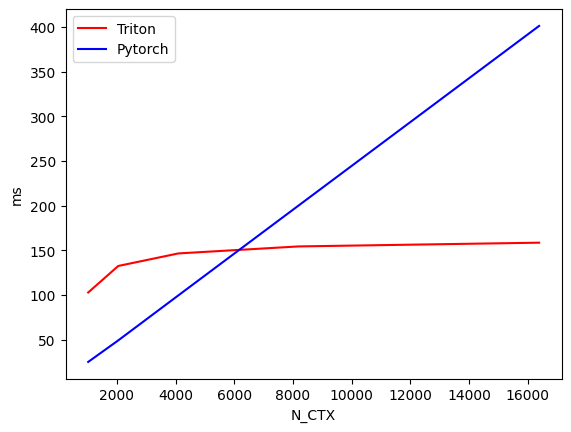

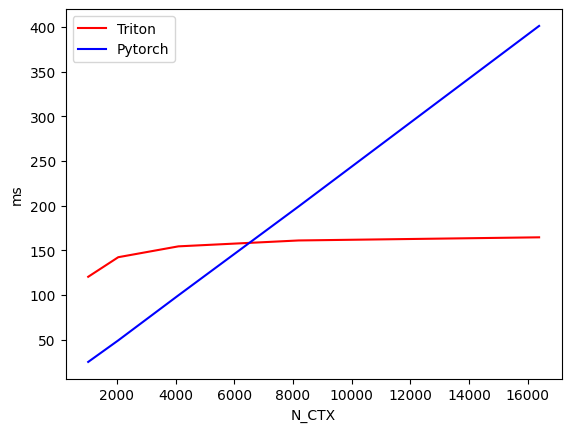

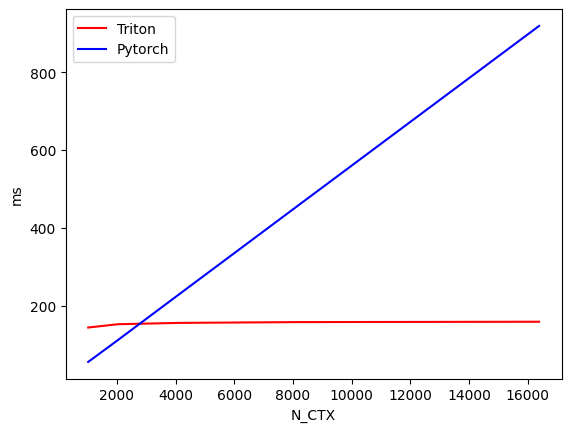

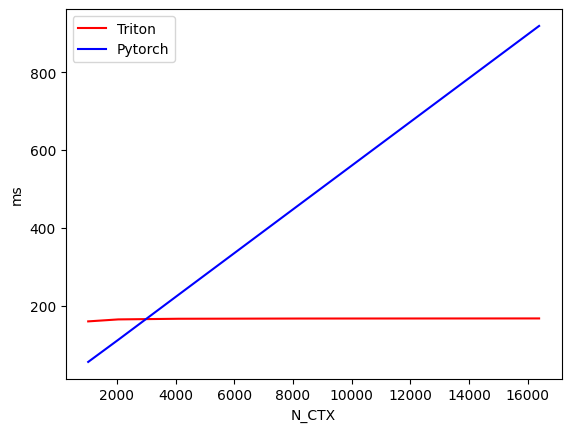

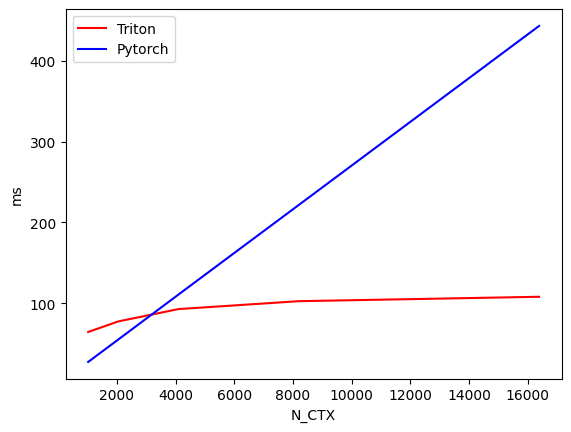

In [36]:
# only works on post-Ampere GPUs right now
bench_flash_attention.run(save_path=".", print_data=True)

In [3]:
from dataclasses import dataclass
from typing import Tuple

CONFIG_DICT = {
    'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
    'gpt-mini':     dict(n_layer=6, n_head=6, n_embd=192),
    'gpt-micro':    dict(n_layer=4, n_head=4, n_embd=128),
    'gpt-nano':     dict(n_layer=3, n_head=3, n_embd=48),
}

@dataclass(frozen=True)
class GPTConfig:
    batch_size: int = 4
    max_length: int = 256
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 64 * 12
    dropout: float = 0.0
    learning_rate: float = 1e-5
    weight_decay: float = 0.01
    betas: Tuple[float, float] = (0.9, 0.999)
    attn_type: str = "torch"
    model_name: str = "Qwen/Qwen1.5-0.5B"
    seed: int = 123
    device: torch.device = torch.device("cuda")
    dtype: torch.dtype = torch.float32
    epochs: int = 2

In [4]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
import lightning

from typing import Callable

import dataclasses
import pathlib
import random

import datasets
from datasets import load_dataset
from huggingface_hub import HfFileSystem
from transformers import AutoConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

import lightning.pytorch
import torch.utils.data


@torch.jit.script
def fused_gelu(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


class TorchCausalSelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        max_length: int,
        dropout: float = 0.0,
        device: torch.device = torch.device("cpu"),
        dtype: torch.dtype = torch.float32,
    ):
        super().__init__()

        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout, device=device, dtype=dtype)
        self.mask = torch.triu(
            torch.full((max_length, max_length), float('-inf'), dtype=dtype, device=device),
            diagonal=1,
        )       
        # self.register_buffer(
        #     "mask",
        #     nn.Transformer.generate_square_subsequent_mask(
        #         max_length, device=device, dtype=dtype
        #     ),
        # )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, t, e = x.size()

        y = self.attn(x, x, x, need_weights=False, attn_mask=self.mask[:t, :t], is_causal=True)[0]

        return y


class TritonCausalSelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        max_length: int,
        dropout: float = 0.0,
        device: torch.device = torch.device("cpu"),
        dtype: torch.dtype = torch.float32,
    ):
        super().__init__()

        self.in_proj = nn.Linear(embed_dim, 3 * embed_dim, bias=False, device=device, dtype=dtype)
        self.attn = TritonAttention.apply
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False, device=device, dtype=dtype)
        self.resid_dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            nn.Transformer.generate_square_subsequent_mask(
                max_length, device=device, dtype=dtype
            ),
        )

        self.num_heads = num_heads

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, t, c = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        k, q, v = torch.split(self.in_proj(x), c, dim=-1)

        k = k.view(b, t, self.num_heads, c // self.num_heads).transpose(1, 2).contiguous()  # (B, nh, T, hs)
        q = q.view(b, t, self.num_heads, c // self.num_heads).transpose(1, 2).contiguous()  # (B, nh, T, hs)
        v = v.view(b, t, self.num_heads, c // self.num_heads).transpose(1, 2).contiguous()  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        y = self.attn(k, q, v, True)
        y = y.transpose(1, 2).contiguous().view(b, t, c) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.out_proj(y))
        return y


class CompiledCausalSelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
    ):
        super().__init__()
    
        self.attn = torch.compile(
            model=PlainFlashAttention(
                embed_dim,
                heads=num_heads,
                dim_head=embed_dim / num_heads,
                causal=True,
                q_bucket_size=128,
                k_bucket_size=128,
                parallel=False,
                mixed_precision=False,
            ),
            dynamic=False,
            mode="reduce-overhead",
            options={"triton.cudagraphs": True},
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.attn(x)

        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, device=config.device, dtype=config.dtype)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, device=config.device, dtype=config.dtype)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = fused_gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class GptBlock(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, device=config.device, dtype=config.dtype)
        if config.attn_type == "torch":
            self.attn = TorchCausalSelfAttention(
                config.n_embd,
                config.n_head,
                config.max_length,
                config.dropout,
                device=config.device,
                dtype=config.dtype
            )
        elif config.attn_type == "triton":
            self.attn = TritonCausalSelfAttention(
                config.n_embd,
                config.n_head,
                config.max_length,
                config.dropout,
                device=config.device,
                dtype=config.dtype,
            )
        elif config.attn_type == "compiled":
            self.attn = CompiledCausalSelfAttention(
                config.n_embd,
                config.n_head,
            ).to(config.device)
        else:
            raise ValueError("Unrecognized attention type:", config.attn_type)
        self.ln_2 = nn.LayerNorm(config.n_embd, device=config.device, dtype=config.dtype)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor):
        x = self.ln_1(x)
        x = x + self.attn(x)
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(lightning.LightningModule):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.max_length = config.max_length
        self.embed_dim = config.n_embd

        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

        vocab_size = len(self.tokenizer)

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, config.n_embd, device=config.device, dtype=config.dtype),
            wpe = nn.Embedding(config.max_length, config.n_embd, device=config.device, dtype=config.dtype),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([GptBlock(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd, device=config.device, dtype=config.dtype),
        ))
        self.lm_head = nn.Linear(config.n_embd, vocab_size, bias=False, device=config.device, dtype=config.dtype)

        self.learning_rate = config.learning_rate
        self.betas = config.betas
        self.weight_decay = config.weight_decay

        self.automatic_optimization = False

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def forward(self, batch_ids: torch.Tensor):
        device = batch_ids.device
        input_ids = batch_ids[:, :-1]
        output_ids = batch_ids[:, 1:]
        b, t = input_ids.size()
        assert t <= self.max_length, f"Cannot forward sequence of length {t}, max length is only {self.max_length}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(input_ids) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits: torch.Tensor = self.lm_head(x)

        # Reshape to calculate cross entropy; the 2D version runs at 50% of the speed of the below version
        loss = F.cross_entropy(logits.reshape(b * t, -1), output_ids.reshape(-1), ignore_index=self.tokenizer.pad_token_id)

        return loss, logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]

        opt = self.optimizers()
        opt.zero_grad()

        loss, logits = self(input_ids)
        self.log("train_loss", loss, prog_bar=True, logger=True)

        # for name, param in self.named_parameters():
        #     print(name, torch.isfinite(param.data).all().numpy().tolist())

        self.manual_backward(loss)
        opt.step()

        # print()
        # print("=======================================")
        # print()
        # for name, param in self.named_parameters():
        #     print(name, torch.isnan(param.data).any().numpy().tolist())

        # raise Exception("stopping")

        return loss

    def configure_optimizers(self):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight'):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)

        # no_decay overrides decay
        decay = decay - no_decay
        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": self.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=self.learning_rate, betas=self.betas)
        return optimizer

    def on_epoch_start(self):
        print('\n')

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at max_length
            idx_cond = idx if idx.size(1) <= self.max_length else idx[:, -self.max_length:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

/home/user/Dropbox/devbox/src/quiet-star/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Compiled version is not working
config = GPTConfig(attn_type="torch", dtype=torch.bfloat16)

lightning.pytorch.seed_everything(config.seed, workers=True)

model = GPT(config)

Seed set to 123
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of parameters: 201.72M


In [6]:
def random_split_on_whitespace(text: str, min_remaining_whitespace: int = 256) -> str:
    """
    Splits a string on a random whitespace character and returns the second part.

    Args:
        text: The string to split.
        min_remaining_whitespace: The minimum number of whitespace characters to leave in string.

    Returns:
        The second part of the string after a random whitespace split, 
        or the original string if no whitespace is found.
        Leading whitespace is stripped.
    """
    whitespace_indexes = [i for i, char in enumerate(text) if char.isspace()][:-min_remaining_whitespace]

    if not whitespace_indexes:
        return text  # Not enough whitespace found, return original text

    random_index = random.choice(whitespace_indexes)

    return text[random_index + 1:].lstrip()


def process_batch(tokenizer: AutoTokenizer, max_length: int = 256) -> Callable[[dict[str, list]], dict[str, list]]:
    def _process(examples: dict[str, list]) -> dict[str, list]:
        result = {
            "input_ids": [
                tokenizer(
                    random_split_on_whitespace(text, max_length + 1),
                    max_length=max_length + 1,
                    truncation=True,
                    padding="max_length"
                )["input_ids"]
                for text in examples["text"]
            ],
        }
        result["text"] = tokenizer.batch_decode(result["input_ids"])
        return result
    
    return _process

In [7]:
fs = HfFileSystem()

# List all ".parquet" files in the repo
paths = fs.glob("datasets/open-web-math/open-web-math/**/*.parquet")
relative_paths = [
    str(pathlib.Path(path).relative_to(*pathlib.Path(path).parts[:3]))
    for path in paths
]

large_dataset = load_dataset(
    "open-web-math/open-web-math",
    data_files={"train": relative_paths[:1]},
    num_proc=8,
    verification_mode=datasets.VerificationMode.NO_CHECKS,
)

small_dataset = large_dataset["train"].select(range(256)).map(
    process_batch(model.tokenizer, config.max_length),
    batched=True,
    remove_columns=["url", "date", "metadata"],
)
small_dataset = small_dataset.remove_columns("text")
small_dataset.set_format("pt", columns=["input_ids"], output_all_columns=True)
small_dataset.save_to_disk("data/open-web-math")

Saving the dataset (1/1 shards): 100%|██████████| 256/256 [00:00<00:00, 66584.51 examples/s]


In [8]:
split_dataset = small_dataset.train_test_split(test_size=0.125, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(split_dataset["train"], batch_size=config.batch_size)
test_dataloader = torch.utils.data.DataLoader(split_dataset["test"], batch_size=config.batch_size)

In [10]:
from lightning.pytorch.callbacks import RichProgressBar

trainer = lightning.pytorch.Trainer(
    deterministic=True,
    accelerator="gpu",
    max_epochs=config.epochs,
    callbacks=[RichProgressBar(leave=True)]
)

trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ transformer │ ModuleDict │  201 M │
│ 1 │ lm_head     │ Linear     │  116 M │
└───┴─────────────┴────────────┴────────┘

Trainable params: 318 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 318 M                                                                                                
Total estimated model params size (MB): 1.3 K

Output()

In [14]:
len(AutoTokenizer.from_pretrained(config.model_name))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


151646